In [1]:
import pandas as pd

# Read both annotation sets
fardouse_annotations = pd.read_csv("annotations/fardouse.csv")
sarah_annotations = pd.read_csv("annotations/sarah.csv")

# Get the set intersection of the completed session ids
shared_set_of_completed_sessions = set(fardouse_annotations["session_id"]).intersection(
    set(sarah_annotations["session_id"])
)

# Get the subsets
fardouse_subset = fardouse_annotations[
    fardouse_annotations["session_id"].isin(shared_set_of_completed_sessions)
]
sarah_subset = sarah_annotations[
    sarah_annotations["session_id"].isin(shared_set_of_completed_sessions)
]

# Replace nan with -1
fardouse_subset = fardouse_subset.fillna(-1)
sarah_subset = sarah_subset.fillna(-1)

# Drop notes column
fardouse_subset = fardouse_subset.drop(columns="notes")
sarah_subset = sarah_subset.drop(columns="notes")

# Drop any Unnamed columns
fardouse_subset = fardouse_subset.loc[:, ~fardouse_subset.columns.str.contains('^Unnamed')]
sarah_subset = sarah_subset.loc[:, ~sarah_subset.columns.str.contains('^Unnamed')]

# Minor cleaning
def select_index_from_option(value: str | int, index_choice: int = 0) -> int:
    if isinstance(value, str):
        if "/" in value:
            return int(value.split("/")[index_choice])
        if "?" in value:
            return int(value.replace("?", ""))
        else:
            return int(value)
    else:
        return int(value)

# Apply the function to the columns
fardouse_subset["period_start_sentence_index"] = fardouse_subset["period_start_sentence_index"].apply(
    lambda x: select_index_from_option(x, -1)
)
fardouse_subset["period_end_sentence_index"] = fardouse_subset["period_end_sentence_index"].apply(
    lambda x: select_index_from_option(x, 0)
)
sarah_subset["period_start_sentence_index"] = sarah_subset["period_start_sentence_index"].apply(
    lambda x: select_index_from_option(x, -1)
)
sarah_subset["period_end_sentence_index"] = sarah_subset["period_end_sentence_index"].apply(
    lambda x: select_index_from_option(x, 0)
)

# Set rows where the period_start_sentence_index is the same as the period_end_sentence_index to -1
fardouse_subset.loc[
    fardouse_subset["period_start_sentence_index"]
    == fardouse_subset["period_end_sentence_index"],
    ["period_start_sentence_index", "period_end_sentence_index"],
] = -1
sarah_subset.loc[
    sarah_subset["period_start_sentence_index"]
    == sarah_subset["period_end_sentence_index"],
    ["period_start_sentence_index", "period_end_sentence_index"],
] = -1

# Show sample
print(len(fardouse_subset), len(sarah_subset))
fardouse_subset.sample(3)

195 198


,session_id,period_start_sentence_index,period_end_sentence_index
189,f38d5ea2dfc5,52,362
188,f18ba226a2cd,49,457
46,9e38a4c12e3f,-1,-1


In [2]:
from segeval import boundary_similarity, convert_positions_to_masses

# Iter over groups of session id and compare the annotations
exact_same = []
within_five = []
different = []
cant_simple_compare = []
boundary_similarities = []

def create_positions_from_indices(session_annotations: pd.DataFrame, total_transcript_length: int) -> list[int]:
    # Convert from list of start and end indicies to "positions"
    # positions format is a list of integers where each integer is an id for the unique section of the meeting
    # i.e. [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3] has three sections
    # First place 1's until the first start index, then 2's until the first end index,
    # then 3's until the second start index, etc.

    # Process positions
    positions = []

    # Get all the start and end indicies in a single ordered list
    start_and_end_indicies = list(
        session_annotations["period_start_sentence_index"].values
    ) + list(session_annotations["period_end_sentence_index"].values)
    start_and_end_indicies.sort()

    # If all values are -1 then return a list of 1's for the entire length
    if all(x == -1 for x in start_and_end_indicies):
        return [1] * total_transcript_length
    
    # Add the total length of the transcript to the end
    start_and_end_indicies.append(total_transcript_length)

    # Iterate over the start and end indicies and add the positions
    previous_boundary_index = 0
    for section_index, sentence_index in enumerate(start_and_end_indicies, start=1):
        length_of_section = sentence_index - previous_boundary_index
        positions.extend([section_index] * length_of_section)
        previous_boundary_index = sentence_index

    return positions


for session_id, fardouse_group in fardouse_subset.groupby("session_id"):
    try:
        # Get the group of session id for Sarah
        sarah_group = sarah_subset[sarah_subset["session_id"] == session_id]

        # If the lengths are both 1 then we can compare simple
        if len(fardouse_group) == 1 and len(sarah_group) == 1:
            # Construct this comparison row
            comparison_row = {
                "session_id": session_id,
                "fardouse_start_index": fardouse_group["period_start_sentence_index"].values[0],
                "fardouse_end_index": fardouse_group["period_end_sentence_index"].values[0],
                "sarah_start_index": sarah_group["period_start_sentence_index"].values[0],
                "sarah_end_index": sarah_group["period_end_sentence_index"].values[0],
            }

            # Check if both the start and end are the same
            if (
                fardouse_group[
                    "period_start_sentence_index"
                ].values[0] == sarah_group["period_start_sentence_index"].values[0]
                and fardouse_group[
                    "period_end_sentence_index"
                ].values[0] == sarah_group["period_end_sentence_index"].values[0]
            ):
                exact_same.append(comparison_row)

            # Check if both of the differences are within 5
            elif (
                abs(
                    fardouse_group["period_start_sentence_index"].values[0]
                    - sarah_group["period_start_sentence_index"].values[0]
                ) <= 5
                and abs(
                    fardouse_group["period_end_sentence_index"].values[0]
                    - sarah_group["period_end_sentence_index"].values[0]
                ) <= 5
            ):
                within_five.append(comparison_row)
            
            # Otherwise they are placed into the different category
            else:
                different.append(comparison_row)
        
        # Read in the full transcript in question to get the total length of the sequence
        transcript = pd.read_csv(f"transcripts/{session_id}.csv")
        total_length_of_transcript = transcript.sentence_index.max() + 1

        # Generate positions
        fardouse_positions = create_positions_from_indices(fardouse_group, total_length_of_transcript)
        sarah_positions = create_positions_from_indices(sarah_group, total_length_of_transcript)

        # Convert to masses
        fardouse_masses = convert_positions_to_masses(fardouse_positions)
        sarah_masses = convert_positions_to_masses(sarah_positions)

        # If length of masses is 1, then just default to 1
        if len(fardouse_masses) == 1 and len(sarah_masses) == 1:
            boundary_similarity_score = 1.0
        # Actually compute boundary similarity
        else:
            boundary_similarity_score = boundary_similarity(
                fardouse_masses,
                sarah_masses,
                n_t=int(total_length_of_transcript * 0.03),
            )

        # Add to the list
        boundary_similarities.append({
            "session_id": session_id,
            "fardouse_masses": fardouse_masses,
            "sarah_masses": sarah_masses,
            "boundary_similarity": float(boundary_similarity_score)
        })

    except Exception:
        cant_simple_compare.append(session_id)
        boundary_similarities.append({
            "session_id": session_id,
            "fardouse_masses": [],
            "sarah_masses": [],
            "boundary_similarity": 0.0
        })

# Convert to dataframes
exact_same = pd.DataFrame(exact_same)
within_five = pd.DataFrame(within_five)
different = pd.DataFrame(different)
boundary_similarities = pd.DataFrame(boundary_similarities)

len(exact_same), len(within_five), len(different)

(111, 26, 52)

# Differences

These sessions have annotations that are different by more than absolute value 5 indices apart.

Correct these in an authoritative sheet.

In [3]:
different

,session_id,fardouse_start_index,fardouse_end_index,sarah_start_index,sarah_end_index
0,09a170e662a5,164,228,-1,-1
1,0aa1f8fcd0ad,52,376,35,376
2,11beb8036e2b,42,634,42,694
3,146b621e98f1,2,502,216,502
4,16dfc4e3ffd1,32,91,23,91
5,18066feac869,33,313,25,313
6,1a60d7dba27c,206,1277,174,1277
7,204e56db5489,-1,-1,35,46
8,2315e3a68f6e,49,722,78,670
9,29290904534e,35,42,41,42


# Cant Compare

These sessions causes errors.... Can you compare them and let me know if you there is a weird annotation value or if something went wrong...

In [4]:
cant_simple_compare

['65c787e775e9', 'ae4ce9d91e16', 'c990c0532e07']

Now downloading: Roboto Condensed
Font saved to: /home/eva/miniforge-pypy3/envs/city-council/lib/python3.10/site-packages/opinionated/fonts
Now downloading: Montserrat
Font saved to: /home/eva/miniforge-pypy3/envs/city-council/lib/python3.10/site-packages/opinionated/fonts
Now downloading: Source Code Pro
Font saved to: /home/eva/miniforge-pypy3/envs/city-council/lib/python3.10/site-packages/opinionated/fonts
Now downloading: Fira Sans
Font saved to: /home/eva/miniforge-pypy3/envs/city-council/lib/python3.10/site-packages/opinionated/fonts
Now downloading: Fira Sans Condensed
Font saved to: /home/eva/miniforge-pypy3/envs/city-council/lib/python3.10/site-packages/opinionated/fonts
Now downloading: IBM Plex Sans
Font saved to: /home/eva/miniforge-pypy3/envs/city-council/lib/python3.10/site-packages/opinionated/fonts
Now downloading: Space Grotesk
Font saved to: /home/eva/miniforge-pypy3/envs/city-council/lib/python3.10/site-packages/opinionated/fonts
Now downloading: Space Mono
Font save

<Axes: xlabel='boundary_similarity'>

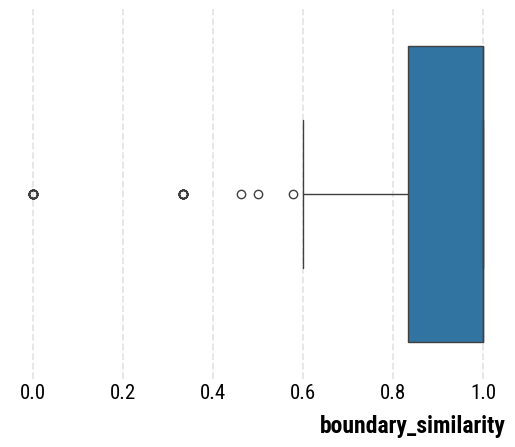

In [5]:
import seaborn as sns
import opinionated
import matplotlib.pyplot as plt
plt.style.use("opinionated_rc")

sns.boxplot(data=boundary_similarities, x="boundary_similarity")

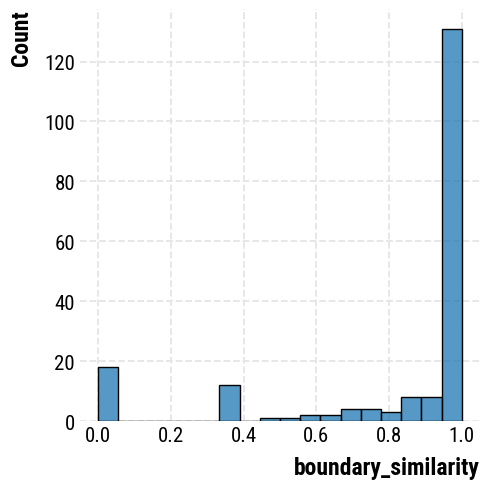

In [6]:
sns.displot(data=boundary_similarities, x="boundary_similarity")